In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('../../../')
from fastai.conv_learner import *
from fastai.dataset import *
from pathlib import Path
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

# check to make sure you set the device
torch.cuda.set_device(0)

useCategories = False
datasetSize = 0

In [4]:
PATH = Path("../../data")
list(PATH.iterdir())

[PosixPath('../../data/list_eval_partition.txt'),
 PosixPath('../../data/modaNet'),
 PosixPath('../../data/list_attr_cloth.txt'),
 PosixPath('../../data/test'),
 PosixPath('../../data/img.zip'),
 PosixPath('../../data/list_attr_img.txt'),
 PosixPath('../../data/full-body.jpg'),
 PosixPath('../../data/img'),
 PosixPath('../../data/tmp'),
 PosixPath('../../data/list_category_cloth.txt'),
 PosixPath('../../data/list_category_img.txt'),
 PosixPath('../../data/list_landmarks.txt'),
 PosixPath('../../data/models'),
 PosixPath('../../data/list_bbox.txt')]

In [6]:
def read_txt_file(path):
    with open(path, "r") as f:
        data = []
        for i, line in enumerate(f):
            if i >= 2:
                data.append(line.split())
    return data

def get_dataframe(path, columns=None, convertList=[]):
    df = pd.DataFrame(read_txt_file(path),columns=columns)
    for i in convertList:
        df[i] = pd.to_numeric(df[i])
    return df

In [7]:
train_test_valid_anot = get_dataframe(PATH/'list_eval_partition.txt',
                                     columns=["Path", "use"])

fileName2bbox = get_dataframe(PATH/'list_bbox.txt',
                             columns=['Path', 'x1', 'y1', 'x2', 'y2'],
                             convertList=["x1","x2","y1","y2"])

fileName2cat = get_dataframe(PATH/'list_category_img.txt',
                            columns=['Path', 'cat'],
                            convertList=["cat"])

cat2type = get_dataframe(PATH/'list_category_cloth.txt',
                        columns=["cat","type"],
                        convertList=["type"])

In [9]:
if useCategories:
    cats = dict((i+1, cat[0]) for i, cat in enumerate(extr_data_txt(PATH/'list_category_cloth.txt')))
else:
    cats = {1: "Top", 2: "Bottoms", 3: "Full Body"}
    cat2type["cat_index"] = np.arange(len(cat2type)) + 1
    cat2type_dict = dict((cat, tp) for cat, tp in zip(cat2type["cat_index"], cat2type["type"]))
    for (cat, tp) in cat2type_dict.items():
        fileName2cat["cat"] = fileName2cat["cat"].replace(cat, tp)

In [10]:
final_ann = fileName2bbox.merge(train_test_valid_anot).merge(fileName2cat)
final_ann = final_ann.reset_index()

if datasetSize:
    final_ann = final_ann[0:datasetSize]

image_ann = dict((ID, [(np.array([y1,x1,y2,x2]), cat_id)])
                 for ID, cat_id, x1, y1, x2, y2 in zip(final_ann["index"],
                                                       final_ann["cat"],
                                                       final_ann["x1"],
                                                       final_ann["y1"],
                                                       final_ann["x2"],
                                                       final_ann["y2"] ))

trn_fns = dict((ID,filename) for ID, filename in zip(final_ann["index"], final_ann["Path"]))
trn_ids = [ID for ID in final_ann["index"]]

In [7]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    draw_im(im, im_a)


In [12]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])


In [9]:
(PATH/"tmp").mkdir(exist_ok=True)
MC_CSV = PATH/'tmp/mc.csv'

In [10]:
mc = [set([cats[p[1]] for p in image_ann[o]]) for o in trn_ids]
mcs = [' '.join(str(p) for p in o) for o in mc]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'clas': mcs}, columns=['fn','clas'])
df.to_csv(MC_CSV, index=False)
df.head()

,fn,clas
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,Top
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,Top
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,Top
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,Top
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,Top


In [11]:
CLAS_CSV = PATH/'tmp/clas.csv'
MBB_CSV = PATH/'tmp/mbb.csv'

f_model=resnet34
sz=224
bs=64

In [12]:
mc = [[cats[p[1]] for p in image_ann[o]] for o in trn_ids]

In [13]:
id2cat = list(cats.values())
cat2id = {v:k for k,v in enumerate(id2cat)}

In [14]:
mcs = np.array([np.array([cat2id[p] for p in o]) for o in mc])
mcs

array([[0],
       [0],
       [0],
       ...,
       [2],
       [2],
       [2]])

In [15]:
val_idxs = final_ann[final_ann["use"] == "test"]["index"]
np.array(val_idxs)

array([     4,      6,     12, ..., 289191, 289211, 289216])

In [16]:
((val_mcs,trn_mcs),) = split_by_idx(val_idxs, mcs)

In [17]:
mbb = [np.concatenate([p[0] for p in image_ann[o]]) for o in trn_ids]
mbbs = [' '.join(str(p) for p in o) for o in mbb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': mbbs}, columns=['fn','bbox'])
df.to_csv(MBB_CSV, index=False)

In [18]:
df.head()

,fn,bbox
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,79 72 273 232
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,59 67 161 155
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,65 65 200 156
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,62 51 182 167
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,88 46 262 166


In [19]:
aug_tfms = [RandomRotate(10, tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
            RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv(PATH, "", MBB_CSV, tfms=tfms, continuous=True, num_workers=4, val_idxs=val_idxs)

In [20]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [21]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [22]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [23]:
x,y=to_np(next(iter(md.val_dl)))
x=md.val_ds.ds.denorm(x)

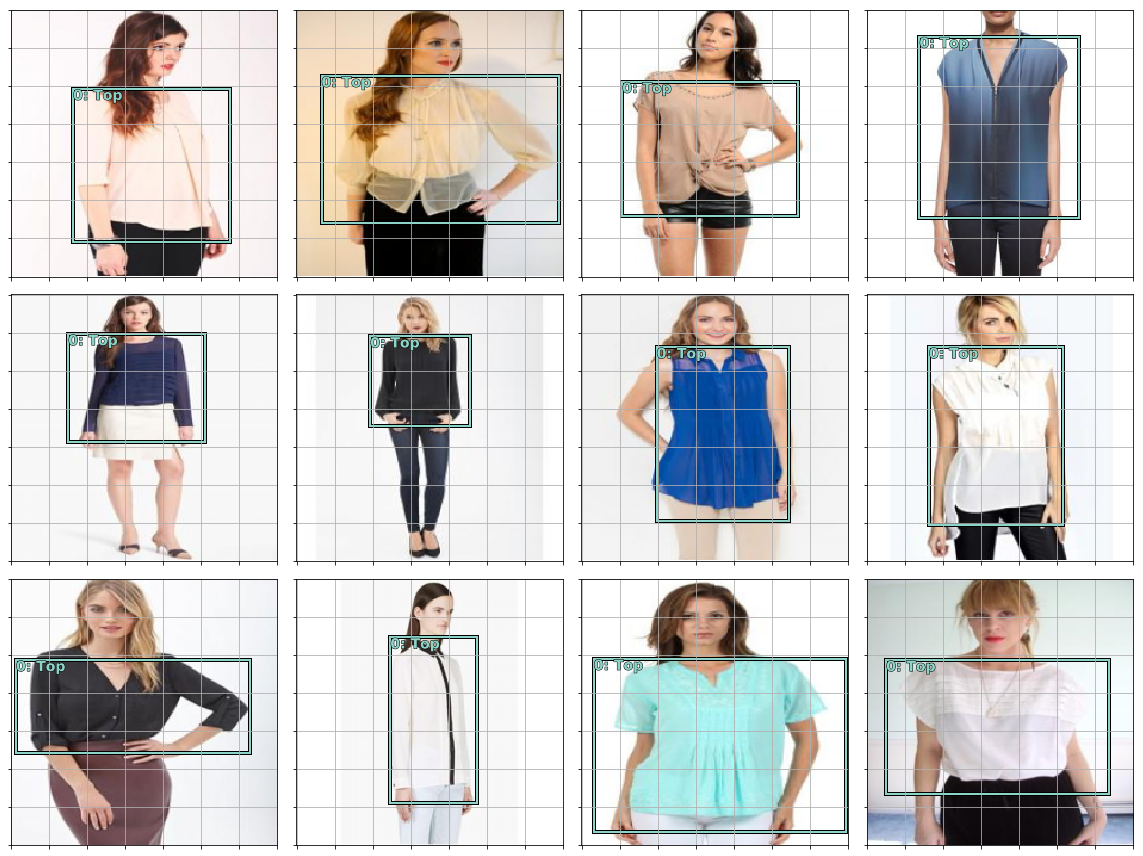

In [24]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

In [26]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

In [27]:
# Grid cell sizes
anc_grids = [4,2,1]
anc_zooms = [0.75, 1., 1.3]
anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]
anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]
k

9

In [28]:
anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

In [29]:
anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1)
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

In [31]:
n_clas = len(id2cat)+1
n_act = k*(4+n_clas)

In [30]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
        
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

In [31]:
class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (len(id2cat)+1)*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

In [35]:
drop = 0.5
class SSD_MultiHead(nn.Module):
    def __init__(self, k, bias, drop=0.1):
        super().__init__()
        self.drop = nn.Dropout(drop)
        self.sconv1 = StdConv(512,256, drop=drop)
        self.sconv2 = StdConv(256,256, drop=drop)
        self.sconv3 = StdConv(256,256, drop=drop)
        self.out0 = OutConv(k, 256, bias)
        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)

    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv1(x)
        o1c,o1l = self.out1(x)
        x = self.sconv2(x)
        o2c,o2l = self.out2(x)
        x = self.sconv3(x)
        o3c,o3l = self.out3(x)
        return [torch.cat([o1c,o2c,o3c], dim=1),
                torch.cat([o1l,o2l,o3l], dim=1)]

head_reg4 = SSD_MultiHead(k, -4.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [36]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = V(t[:,:-1].contiguous())#.cpu()
        x = pred[:,:-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,2.
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

loss_f = FocalLoss(len(id2cat))

In [37]:
def intersect(box_a, box_b):
    """ Returns the intersection of two boxes """
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): 
    """ Returns the box size"""
    return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    """ Returns the jaccard distance between two boxes"""
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

def get_y(bbox,clas):
    """ ??? """
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

def actn_to_bb(actn, anchors):
    """ activations to bounding boxes """
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    """ ?? """
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False):
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(id2cat)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

In [38]:
learn.crit = ssd_loss

 65%|██████▍   | 2523/3895 [28:01<19:54,  1.15it/s, loss=94.7] 

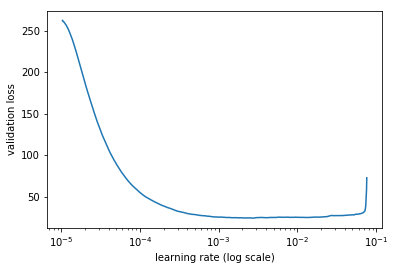

In [77]:
learn.lr_find()
learn.sched.plot(n_skip_end=2)

In [72]:
lr = 1e-4
learn.fit(lr, 1, cycle_len=4, use_clr=(20,8))
learn.save("cloth_det")

epoch      trn_loss   val_loss                                 
    0      4.589817   4.395336  
    1      4.256202   4.06033                                  
    2      4.15794    3.911948                                  
    3      4.032552   3.838676                                 


[array([3.83868])]

In [39]:
learn.load("cloth_det")

In [ ]:
lr = 1e-4
lrs = [lr/100, lr/5, lr]
learn.freeze_to(-2)
learn.fit(lrs, 1, cycle_len=4, use_clr=(20,8))
learn.save("cloth_det2")

epoch      trn_loss   val_loss                                  
    0      3.756477   3.548061  
    1      3.558168   3.357121                                  
    2      3.348496   3.238925                                  
Validation:  95%|█████████▍| 592/625 [05:04<00:13,  2.42it/s]   

In [40]:
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*224).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)

In [42]:
def plot_results(thresh):
    x,y = next(iter(md.val_dl))
    y = V(y)
    batch = learn.model(V(x))
    b_clas,b_bb = batch

    x = to_np(x)
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    for idx,ax in enumerate(axes.flat):
        ima=md.val_ds.ds.denorm(x)[idx]
        bbox,clas = get_y(y[0][idx], y[1][idx])
        a_ic = actn_to_bb(b_bb[idx], anchors)
        clas_pr, clas_ids = b_clas[idx].max(1)
        clas_pr = clas_pr.sigmoid()
        torch_gt(ax, ima, a_ic, clas_ids, clas_pr, clas_pr.max().data[0]*thresh)
    plt.tight_layout()

In [38]:
class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,2.
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

loss_f = FocalLoss(len(id2cat))

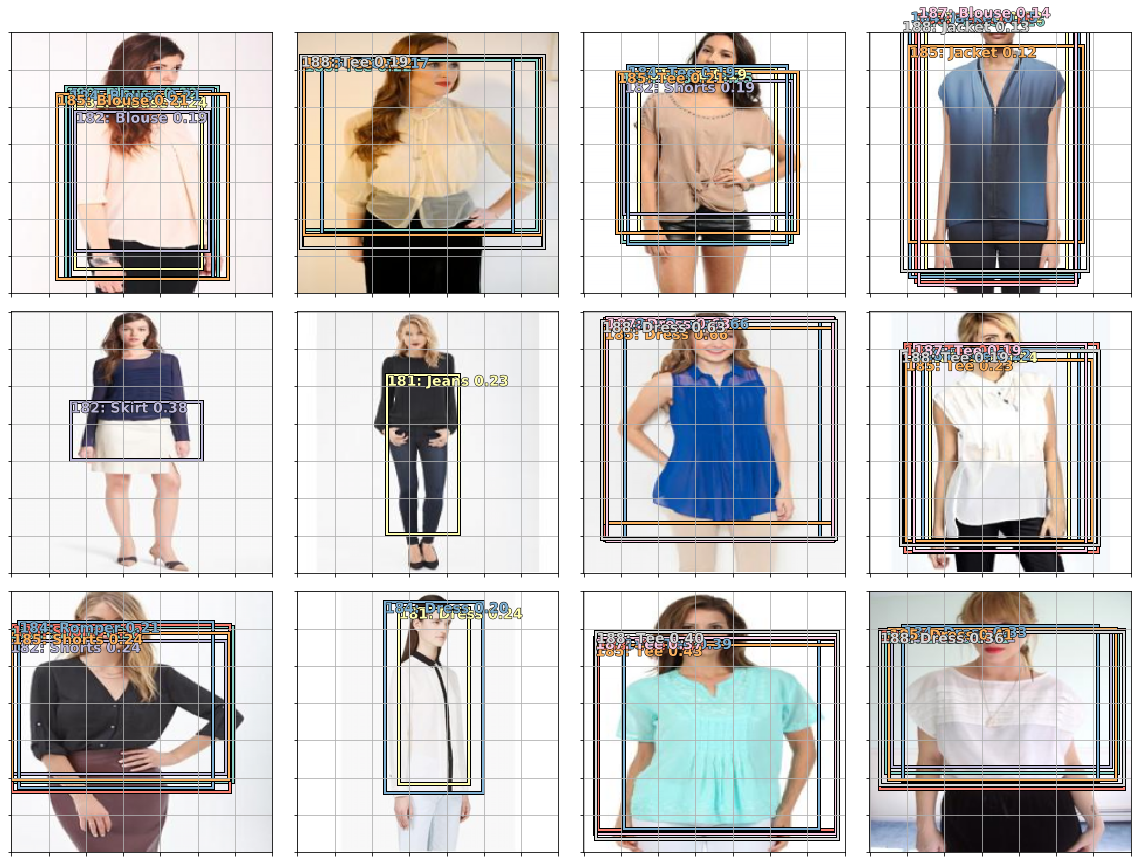

In [43]:
plot_results(0.75)

In [54]:
def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count

In [57]:

def get1preds(b_clas,b_bb,bbox,clas,thresh=0.25):
    bbox,clas = get_y(bbox, clas)
    a_ic = actn_to_bb(b_bb, anchors)
    clas_pr, clas_ids = b_clas.max(1)
    conf_scores = b_clas.sigmoid().t().data
    out1,out2,cc = [],[],[]
    for cl in range(conf_scores.size(0)-1):
        cl_mask = conf_scores[cl] > thresh
        if cl_mask.sum() == 0: continue
        scores = conf_scores[cl][cl_mask]
        l_mask = cl_mask.unsqueeze(1).expand_as(a_ic)
        boxes = a_ic[l_mask].view(-1, 4)
        ids, count = nms(boxes.data, scores, 0.4, 50)
        ids = ids[:count]
        out1.append(scores[ids])
        out2.append(boxes.data[ids])
        cc.append([cl]*count)
    cc = T(np.concatenate(cc)) if cc != [] else None
    out1 = torch.cat(out1) if out1 != [] else None
    out2 = torch.cat(out2) if out2 != [] else None
    return out1,out2,cc

def count(L):
    result = collections.defaultdict(int)
    if L is not None:
        for x in L:
            result[x] += 1
    return result

from ipywidgets import FloatProgress
from IPython.display import display
def multiTPFPFN():
    n = 40
    threshes = np.linspace(.05, 0.95, n, endpoint=True)
    tps,fps,fns = np.zeros((n,len(id2cat))),np.zeros((n,len(id2cat))),np.zeros((n,len(id2cat)))
    prog = FloatProgress(min=0,max=len(md.val_dl))
    display(prog)
    for data in md.val_dl:
        x,y = data
        x,y = V(x),V(y)
        pred = learn.model(x)
        for idx in range(x.size(0)):
            bbox,clas = get_y(y[0][idx],y[1][idx])#unpad the target
            p_scrs,p_box,p_cls = get1preds(pred[0][idx],pred[1][idx],y[0][idx],y[1][idx],threshes[0])
            overlaps = to_np(jaccard(p_box,bbox.data))
            overlaps = np.where(overlaps > 0.5, overlaps, 0)
            clas, np_scrs, np_cls = to_np(clas.data),to_np(p_scrs), to_np(p_cls)
            for k in range(threshes.shape[0]):
                new_tp = collections.defaultdict(int)
                for cls in list(set(clas)):
                    msk_clas = np.bitwise_and((clas == cls)[None,:],(np_cls == cls)[:,None])
                    ov_clas = np.where(msk_clas,overlaps,0.)
                    mx_idx = np.argmax(ov_clas,axis=1)
                    for i in range(0,len(clas)):
                        if (clas[i] == cls):
                            keep = np.bitwise_and(np.max(ov_clas,axis=1) > 0.,mx_idx==i)
                            keep = np.bitwise_and(keep,np_scrs > threshes[k])
                            if keep.sum() > 0:
                                new_tp[cls] += 1
                count_pred = count(np_cls[np_scrs > threshes[k]])
                count_gt = count(clas)
                for c in range(len(id2cat)):
                    tps[k,c] += new_tp[c]
                    fps[k,c] += count_pred[c] - new_tp[c]
                    fns[k,c] += count_gt[c] - new_tp[c]
        prog.value += 1 
    return tps, fps, fns

In [58]:
tps, fps, fns = multiTPFPFN()

def avg_prec(clas):
    eps = 1e-15
    precisions = tps[:,clas]/(tps[:,clas] + fps[:,clas] + eps)
    recalls = tps[:,clas]/(tps[:,clas] + fns[:,clas] + eps)
    prec_at_rec = []
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args = np.argwhere(recalls >= recall_level).flatten()
            prec = max(precisions[args])
        except ValueError:
            prec = 0.0
        prec_at_rec.append(prec)
    return np.array(prec_at_rec).mean()

def mAP():
    S = 0
    for i in range(len(id2cat)):
        S += avg_prec(i)
    return S/len(id2cat)

FloatProgress(value=0.0, max=625.0)

In [59]:
mAP()

0.050529216621253266